# <center> Análisis de la eficiencia de los Lanzamientos de los Cy-Youngs Temporadas 2020 y 2021 </center>

| Para una mejor experiencia interactiva (en Binder) SE RECOMIENDA: |
|:--:| 
| 1. Ocultar el código: View --> Collapse All Code |
| 2. Correr todo el libro: Run --> Run All Cells|
| 3. Ir a la **sección 1** de este libro y **escoger picher y temporada** |
| 4. Correr el libro desde sección 2: Run --> Run Selected Cell and All Below|

In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher,utils

In [38]:
matplotlib inline

In [39]:
from ipywidgets import interact, interactive, fixed, interact_manual,Button, HBox, VBox
import ipywidgets as widgets


## 1. Selección de pitcher y temporada (fuente:Statscast - librería:pybaseball)

In [42]:
list_pitchers = ['trevor-bauer','shane-bieber','robbie-Ray', 'corbin-burnes']
seasons = ['2021-04-01/2021-10-03','2020-07-23/2020-10-27']

p = widgets.Dropdown(
                    options=list_pitchers,
                    description="Pitcher"
                    )
s = widgets.Dropdown(
                    options=seasons, 
                    description="Season"
                    )
def f(p,s):
    return p,s    

out = widgets.interactive_output(f, {'p': p,'s': s})
widgets.VBox([p,s, out]);

##  2. Pitcher y temporada escogida

In [27]:
pl = playerid_lookup(p.value.split('-')[1], p.value.split('-')[0])
key = pl['key_mlbam'].iloc[0]
player = statcast_pitcher(s.value.split('/')[0],s.value.split('/')[1], key)
print('---------------------------------------------------------------------')
print('Se analizará la data del pitcher: {} {} en la temporada {}'. format(
                                                        pl['name_first'].iloc[0], 
                                                        pl['name_last'].iloc[0],
                                                        s.value.split('/')[1][0:4]
                                                        ))

Gathering Player Data
---------------------------------------------------------------------
Se analizará la data del pitcher: trevor bauer en la temporada 2021


In [28]:
dd = player

#ajuste a formato válido de formato de fecha
dd['game_date'] = dd['game_date'].astype('datetime64[ns]')

# clean data
dd_clean=dd.drop(dd[dd['pitch_type'].isna()].index)
#print('--------------------------------------------------')
#print('Picheos antes del data clean', dd.shape[0]) 
#print('Picheos despues del data clean', dd_clean.shape[0])


## 3. Distribución de Velocidades por Tipo de Lanzamiento y localización.

In [29]:
#indexado por fecha de los juegos
index_games= dd_clean.groupby(dd_clean['game_date']).sum().index

#definición de columnas de interés
tipos_lanzamientos = dd_clean.groupby('pitch_type')['pitch_type'].count().index #CU, FF, SL, etc
tipos_eventos = dd_clean.groupby('events')['events'].count().index        # Anotación Oficial: Single, Double, walk, K, etc
tipos_batazos = dd_clean.groupby('bb_type')['bb_type'].count().index      # fly_ball, ground_ball, etc


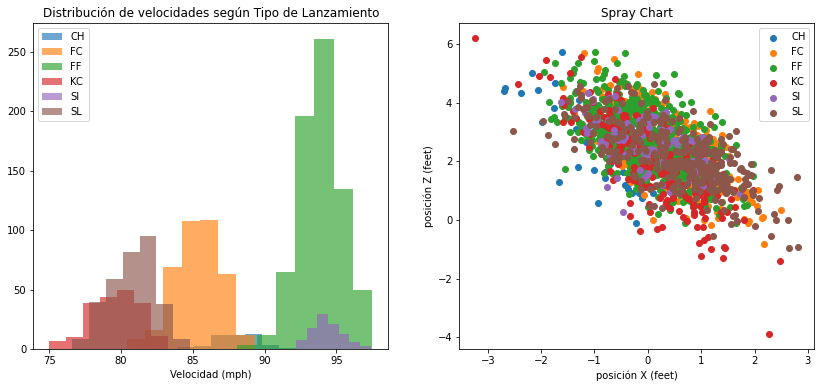

In [30]:
fig, axs = plt.subplots(1,2,figsize=(14, 6))

for tipo in tipos_lanzamientos:
    axs[0].hist(dd_clean[dd_clean['pitch_type']==tipo].release_speed,7, label=tipo, alpha=0.65)
    axs[1].scatter(dd_clean[dd_clean['pitch_type']==tipo].plate_x,dd_clean[dd_clean['pitch_type']==tipo].plate_z, label=tipo)

axs[0].legend()
axs[0].set_xlabel('Velocidad (mph)')
axs[0].set_title('Distribución de velocidades según Tipo de Lanzamiento');

axs[1].legend()
axs[1].set_xlabel('posición X (feet)')
axs[1].set_ylabel('posición Z (feet)')
axs[1].set_title('Spray Chart');

## 4. Distribución de los Tipo de Lanzamientos y resultados (strike, bola, X)

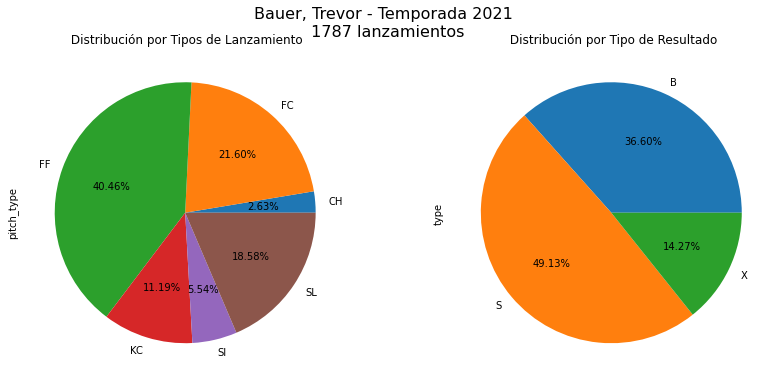

In [31]:
fig0, axes0 = plt.subplots(1,2,figsize=(14, 6))
fig0.suptitle( '{} - Temporada {} \n {:d} lanzamientos'. format( 
                    dd_clean.player_name[0],
                    s.value.split('/')[1][0:4],
                    dd_clean.groupby('type')['type'].count().sum() ),
                    fontsize=16)

dd_clean.groupby('pitch_type')['pitch_type'].count().plot.pie(title='\n Distribución por Tipos de Lanzamiento',
                                                    ax=axes0[0],autopct='%1.2f%%');

dd_clean.groupby('type')['type'].count().plot.pie(
                                                title='\n Distribución por Tipo de Resultado', 
                                                ax=axes0[1],autopct='%1.2f%%'
                                                );


## 5. Análisis de las conexiones hechas por los bateadores

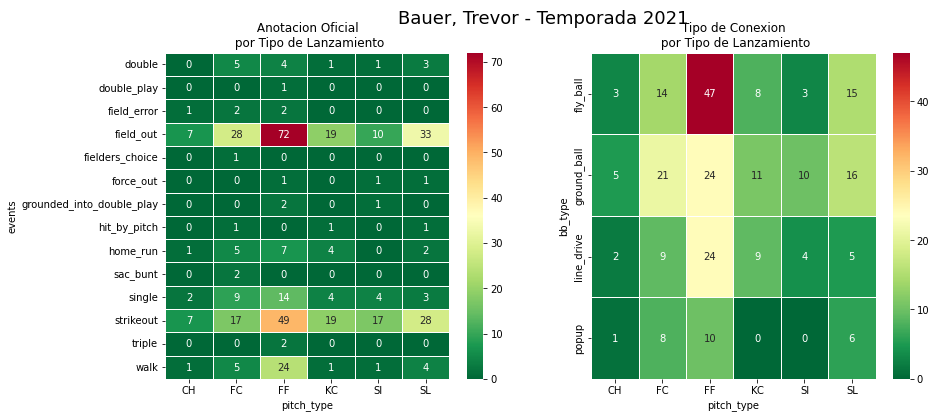

In [32]:

# Anotación Oficial (eventos) por Tipo de Lanzamiento
dm = pd.DataFrame(columns=tipos_lanzamientos,index=tipos_eventos)
for tl in tipos_lanzamientos:
    g=dd_clean[dd_clean['pitch_type']==tl]
    for te in tipos_eventos:
        dm.loc[te,tl]=float(g[g['events']==te].shape[0])
dm = dm.apply(pd.to_numeric)

# Tipo de conexión (o batazo) por Tipo de Lanzamiento
df = pd.DataFrame(columns=tipos_lanzamientos,index=tipos_batazos)
for tl in tipos_lanzamientos:
    d=dd_clean[dd_clean['pitch_type']==tl]
    for tb in tipos_batazos:
        df.loc[tb,tl]=float(d[d['bb_type']==tb].shape[0])
df = df.apply(pd.to_numeric)

# Graficas de los data frames dm y df
fig1, axes1 = plt.subplots(1,2,figsize=(14, 6))
fig1.suptitle('{} - Temporada {}'. format(
                                        dd_clean.player_name[0],
                                        s.value.split('/')[1][:4]), 
                                        fontsize=18)

sns.heatmap(dm,cmap='RdYlGn_r', linewidths=0.5, annot=True,ax=axes1[0])
sns.heatmap(df,cmap='RdYlGn_r', linewidths=0.5, annot=True,ax=axes1[1])

axes1[0].set_title('\n Anotacion Oficial \n por Tipo de Lanzamiento');
axes1[1].set_title('\n Tipo de Conexion \n por Tipo de Lanzamiento');

## 6. Interacción para  visualizar la distribución de los eventos según la combinación: tipos de lanzamiento y forma del batazo

In [33]:
@widgets.interact_manual(tipoLanzamiento = list(tipos_lanzamientos.values), TB = list(tipos_batazos.values) )

def pieResult(tipoLanzamiento='SL',TB ='fly_ball'):
    
    fig2, axes2 = plt.subplots(1,2,figsize=(14, 6))
    fig2.suptitle('{} - Temporada {}'. format(
                                            dd_clean.player_name[0],
                                            s.value.split('/')[1][:4] ),
                                             fontsize=18)
    
    sns.heatmap(df,cmap='RdYlGn_r', linewidths=0.5, annot=True,ax=axes2[0])
    
    dm = dd_clean[(dd_clean['pitch_type']==tipoLanzamiento) & (dd_clean['bb_type']==TB)]
    dm.groupby('events')['events'].count().plot.pie(title='titulo',
                                                    ax=axes2[1],autopct='%1.2f%%')
    
    axes2[0].set_title('Lanzamientos conectados por bateadores: {:d}'. format(int( df.sum().sum()) ) )
    axes2[1].set_title('Distribución (por Anotación Oficial) de los {:d} {} que resultaron en {}'. format( int( df.loc[TB,tipoLanzamiento]), tipoLanzamiento, TB ) )
    

interactive(children=(Dropdown(description='tipoLanzamiento', index=5, options=('CH', 'FC', 'FF', 'KC', 'SI', …